In [1]:
import gymnasium as gym
import gym_donkeycar

import os
from ruamel.yaml import YAML
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display
from tqdm import tqdm

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import distributions as dist
from torch.distributions import Normal, Categorical

import torchvision
from torchvision import transforms

from tensorboard import notebook
from torch.utils.tensorboard import SummaryWriter

# Set the environment variable to suppress TensorFlow warning
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from networks.utils import to_np, load_config

# custom classes and functions
from networks.blocks import ConvBlock, CategoricalStraightThrough
from networks.rssm import RSSM
from networks.mlp import MLP
from networks.categorical_vae import CategoricalVAE
from networks.actor_critic import ContinuousActorCritic
from preprocessing import grayscale_transform as transform

torch.cuda.empty_cache()
%matplotlib inline

/home/till/.local/lib/python3.10/site-packages/gymnasium/envs/registration.py:498: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [2]:
device = torch.device("cpu")

## Init the environment

## Playground  \~( ˘▾˘~)

## AC training loop for Cartpole

In [9]:
# environment hyperparams
n_envs = 10
n_updates = 5000
n_steps_per_update = 128

agent = ContinuousActorCritic(
     n_features=3, 
     n_actions=1,
     n_envs=n_envs,
     gamma=0.99,
     lam=0.95,
     entropy_coeff=0.01, # 0.01
     critic_lr=0.005,
     actor_lr=0.001
).to(device)

In [10]:
# create a wrapper environment to save episode returns and episode lengths

envs = gym.vector.make("Pendulum-v1", num_envs=n_envs, max_episode_steps=200)
envs_wrapper = gym.wrappers.RecordEpisodeStatistics(envs, deque_size=n_envs*n_updates)

critic_losses = []
actor_losses = []
entropies = []

for sample_phase in tqdm(range(n_updates)):
    
    # we don't have to reset the envs, they just continue playing
    # until the episode is over and then reset automatically

    ep_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_rewards = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_entropies = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_masks = torch.zeros(n_steps_per_update, n_envs, device=device)

    if sample_phase == 0:
        obs, info = envs_wrapper.reset(seed=0)
        obs = torch.Tensor(obs)

    for step in range(n_steps_per_update):
        
        # get action and value
        action, log_prob, actor_entropy = agent.get_action(obs)
        value_pred = agent.critic(obs)

        # env step
        obs, reward, terminated, truncated, infos = envs_wrapper.step(to_np(action))
        obs = torch.Tensor(obs)

        ep_value_preds[step] = value_pred.squeeze()
        ep_rewards[step] = torch.tensor(reward, device=device)
        ep_log_probs[step] = log_prob.squeeze()
        ep_entropies[step] = actor_entropy.squeeze()

        # add a mask (for the return calculation later);
        # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
        ep_masks[step] = torch.Tensor([not term for term in terminated], device=device)

    # calculate the losses for actor and critic
    critic_loss, actor_loss = agent.get_loss(ep_rewards, ep_log_probs, ep_value_preds, ep_entropies, ep_masks)

    # update the actor and critic networks
    agent.update_parameters(critic_loss, actor_loss)

    # log the losses and entropy
    critic_losses.append(to_np(critic_loss))
    actor_losses.append(to_np(actor_loss))
    entropies.append(to_np(ep_entropies.mean()))

  0%|                                                                                                  | 0/5000 [00:00<?, ?it/s]/home/till/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
 13%|███████████▏                                                                            | 635/5000 [02:32<17:29,  4.16it/s]


KeyboardInterrupt: 

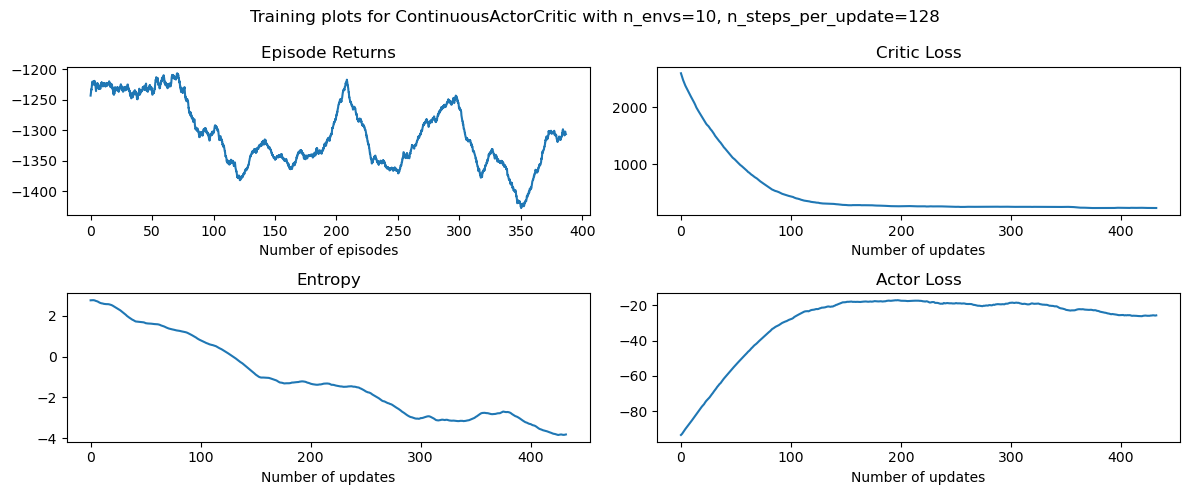

In [11]:
""" Plot the results """

rolling_length = max(1, int(len(envs_wrapper.return_queue) / 20))

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
fig.suptitle(f"Training plots for {agent.__class__.__name__} with n_envs={n_envs}, n_steps_per_update={n_steps_per_update}")

# Episode return
axs[0, 0].set_title("Episode Returns")
episode_returns_moving_average = np.convolve(np.array(envs_wrapper.return_queue).flatten(), np.ones(rolling_length), mode="valid") / rolling_length
axs[0, 0].plot(np.arange(len(episode_returns_moving_average)) / n_envs, episode_returns_moving_average)
axs[0, 0].set_xlabel("Number of episodes")

# Entropy
axs[1, 0].set_title("Entropy")
entropy_moving_average = np.convolve(np.array(entropies), np.ones(rolling_length), mode="valid") / rolling_length
axs[1, 0].plot(entropy_moving_average)
axs[1, 0].set_xlabel("Number of updates")

# Critic loss
axs[0, 1].set_title("Critic Loss")
critic_losses_moving_average = np.convolve(np.array(critic_losses).flatten(), np.ones(rolling_length), mode="valid") / rolling_length
axs[0, 1].plot(critic_losses_moving_average)
axs[0, 1].set_xlabel("Number of updates")

# Actor loss
axs[1, 1].set_title("Actor Loss")
actor_losses_moving_average = np.convolve(np.array(actor_losses).flatten(), np.ones(rolling_length), mode="valid") / rolling_length
axs[1, 1].plot(actor_losses_moving_average)
axs[1, 1].set_xlabel("Number of updates")

plt.tight_layout()
plt.show()

## Showcase

In [13]:
envs = gym.vector.make("Pendulum-v1", num_envs=1, max_episode_steps=200, render_mode="human")

obs, info = envs.reset(seed=0)
obs = torch.Tensor(obs)

for step in range(n_steps_per_update):
    
    # get action and value
    action, action_log_probs, actor_entropy = agent.get_action(obs)
    value = agent.critic(obs)
    
    # env step
    obs, rewards, terminated, truncated, infos = envs.step(to_np(action))
    obs = torch.Tensor(obs)

envs.close()

/home/till/.local/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
